# Vehicle Detection
In this project we will implement a vehicle detection system that will identify cars with bounding boxes in a video stream. 

Here are the steps in building the vehichle detection system,
1. Build feature vectors of cars and noncar images
    - Spatial Binning
    - HOG features
2. Train a classifier over the feature vectors
3. Build a sliding window model to extract sections of image that can be input to the classifier to predict if there is a car or not
4. Solve for false positives and duplicate detections
5. Build a pipeline with the above parts

In [1]:
# Some basic imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import features as ft
import pickle

%matplotlib inline

In [2]:
# lets load the train data and explore some feature vector

cars = glob.glob("./train_data/vehicles/*/*.png")
print("cars input size :",len(cars))
non_cars = glob.glob("./train_data/non-vehicles/*/*.png")
print("non-cars input size :", len(non_cars))

cars input size : 8792
non-cars input size : 8968


img shape: (64, 64, 3)


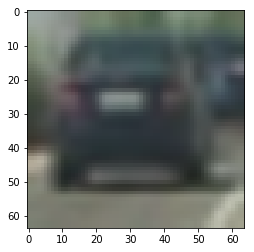

In [3]:
img  = mpimg.imread(cars[0])
print("img shape:", img.shape)
plt.imshow(img)


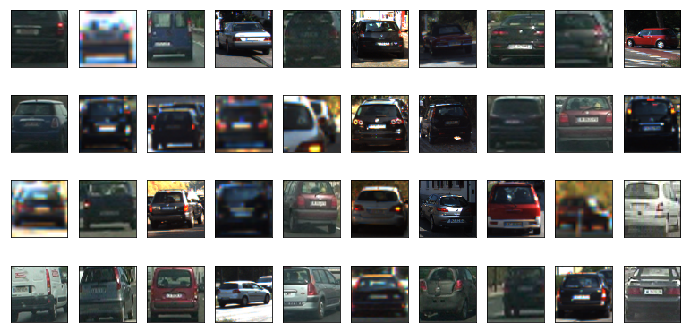

In [4]:
def displayImages(image_files):
    fig = plt.figure(figsize=(12, 6))
    for i in range(0, 40):
        number = np.random.randint(0, len(image_files))
        axis = fig.add_subplot(4,10,i+1)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        axis.imshow(mpimg.imread(image_files[number]))
    plt.show()

displayImages(cars)

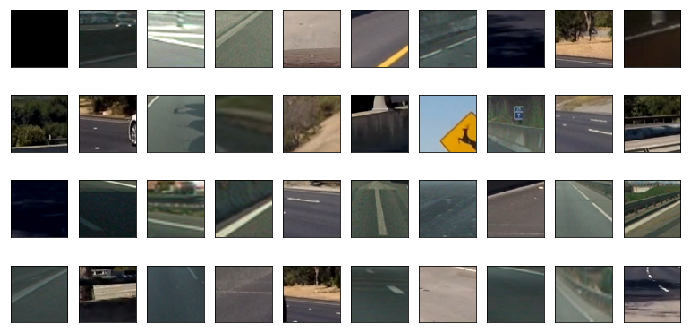

In [5]:
displayImages(non_cars)

### Feature Engineering

##### Color Histogram

In [6]:
def color_hist(img, nbins=32, bins_range=(0,256), debug = False) :
    rhist = np.histogram(img[:,:,0] , nbins, bins_range)
    ghist = np.histogram(img[:,:,1] , nbins, bins_range)
    bhist = np.histogram(img[:,:,2] , nbins, bins_range)
    
    hist_features_vec= np.concatenate((rhist[0],ghist[0],bhist[0]))
    
    if(debug == True) :
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
        return hist_features_vec, rhist,ghist, bhist, bin_centers
    else :
        return hist_features_vec

In [7]:
car_img = mpimg.imread(cars[0]) 

np.max(car_img)

0.75294119

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd7336fbba8>,
 <Container object of 10 artists>,
 (0, 1.0),
 <matplotlib.text.Text at 0x7fd733733ac8>)

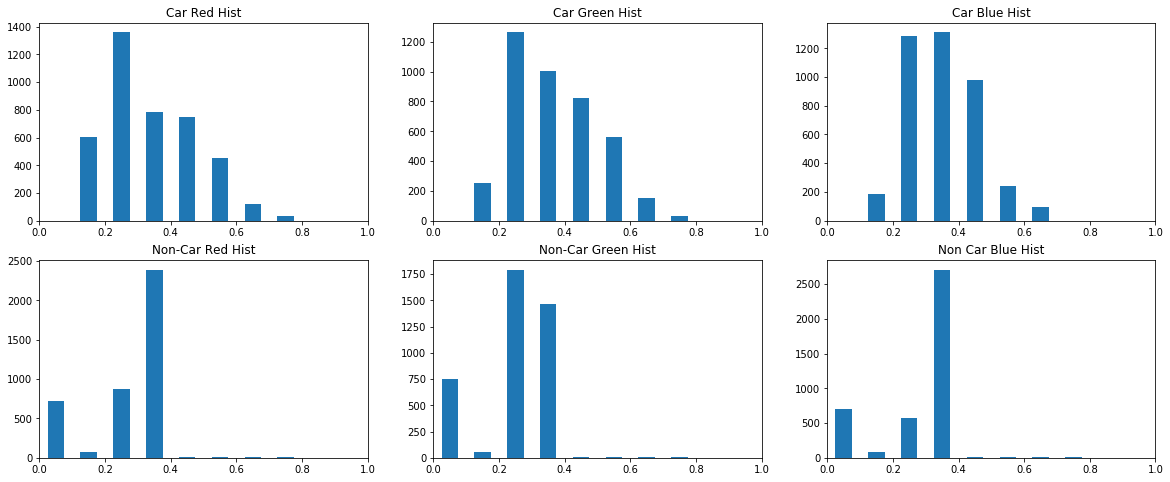

In [8]:
car_img = mpimg.imread(cars[0]) 

nbins=32
bins_range =(0,256)
bar_width = 1
if np.max(car_img) <= 1: # likely png read through matplotlib. it would be scaled to (0,1) range
    nbins = 10
    bins_range = (0,1.0)
    bar_width = 0.05
    
hist_vec, rhist, ghist, bhist, bin_centers = color_hist(car_img,nbins=nbins,bins_range=bins_range, debug=True)

fig = plt.figure(figsize=(20,8))
plt.subplot(231), plt.bar(bin_centers, rhist[0], width=bar_width), plt.xlim(bins_range), plt.title("Car Red Hist")
plt.subplot(232), plt.bar(bin_centers, ghist[0], width=bar_width), plt.xlim(bins_range), plt.title("Car Green Hist")
plt.subplot(233), plt.bar(bin_centers, bhist[0], width=bar_width), plt.xlim(bins_range), plt.title("Car Blue Hist")

non_car_img = mpimg.imread(non_cars[20])
hist_vec, rhist, ghist, bhist, bin_centers = color_hist(non_car_img,nbins=nbins,bins_range=bins_range, debug=True)
plt.subplot(234), plt.bar(bin_centers, rhist[0], width=bar_width), plt.xlim(bins_range), plt.title("Non-Car Red Hist")
plt.subplot(235), plt.bar(bin_centers, ghist[0], width=bar_width), plt.xlim(bins_range), plt.title("Non-Car Green Hist")
plt.subplot(236), plt.bar(bin_centers, bhist[0], width=bar_width), plt.xlim(bins_range), plt.title("Non Car Blue Hist")


In [9]:
hist_vec.shape

(30,)

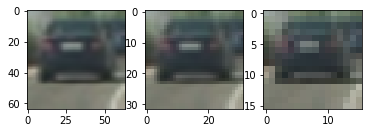

In [10]:
car_img = mpimg.imread(cars[1]) 

plt.subplot(131)
plt.imshow(car_img)
plt.subplot(132)
plt.imshow(cv2.resize(car_img,(32,32)))
plt.subplot(133)
plt.imshow(cv2.resize(car_img,(16,16)))

##### Spatial Binning

In [11]:

def spatial_bin_features(img,size=(32,32)) :
    features= cv2.resize(img, size).ravel()
    return features



In [12]:
spatial_features = spatial_bin_features(car_img, (16,16))
spatial_features.shape

(768,)

##### Histogram Of Gradients

In [13]:
from skimage.feature import hog

def cvt_2_colorspace(rgb_img, cspace='RGB') :
    """
    Converts rgb_img to the colorspace defined int he 
    """
    if cspace != 'RGB':
        if cspace == 'HSV' :
            feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        elif cspace == 'HLS' :
            feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
        elif cspace == 'LUV' :
            feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LUV)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)
        else :
            raise ValueError("Unknown cspace parameter - " + cspace)
    else :
        feature_image = np.copy(rgb_img)
    
    return feature_image

def get_hog_features(img, orient, pix_per_cell, cell_per_blk, transform_sqrt=True, vis=False, feature_vec = True) :
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_blk, cell_per_blk), transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else :
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_blk, cell_per_blk), transform_sqrt=transform_sqrt, 
                            visualise=vis, feature_vector=feature_vec)
    return features


In [14]:
feature_image = cvt_2_colorspace(car_img, cspace='YCrCb')

hog_features_list=[]
hog_features, hog_image1 = get_hog_features(
    feature_image[:,:,0], orient=9, pix_per_cell=8, cell_per_blk=2, transform_sqrt=True, vis=True, feature_vec = True)
hog_features_list.append(hog_features)
hog_features, hog_image2 = get_hog_features(
    feature_image[:,:,1], orient=9, pix_per_cell=8, cell_per_blk=2, transform_sqrt=True, vis=True, feature_vec = True)
hog_features_list.append(hog_features)

hog_features, hog_image3= get_hog_features(
    feature_image[:,:,2], orient=9, pix_per_cell=8, cell_per_blk=2, vis=True, feature_vec = True)
hog_features_list.append(hog_features)



In [15]:
hf = np.ravel(hog_features_list)
hf.shape

(5292,)

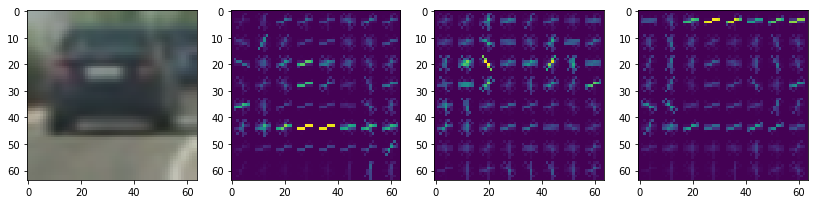

In [16]:
fig = plt.figure(figsize=(14,8))
plt.subplot(141)
plt.imshow(car_img)
plt.subplot(142)
plt.imshow(hog_image1)
plt.subplot(143)
plt.imshow(hog_image2)
plt.subplot(144)
plt.imshow(hog_image3)

### Classifier
Next step is to build a classifier that can identify cars and non-car images. Once we build this classifier we can use with an image segmentation module to identify where a car is in the image.

In [17]:
from sklearn.model_selection import train_test_split

# extract_features method - to create features for different classes
# 
def extract_features(imgs, cspace='RGB',include_color_features=False,
                     spatial_size=(32, 32),hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features=[]
    for file in imgs: 
        img = mpimg.imread(file)
        feature_image = cvt_2_colorspace(img, cspace=cspace)
        # 1. add hog features
        if hog_channel =='ALL' :
            hog_features = []
            for i in range(feature_image.shape[2]) :
                hog_features.append(
                    get_hog_features(feature_image[:,:,i], 
                                     orient, pix_per_cell, cell_per_block, vis=False, feature_vec= True))
            hog_features = np.ravel(hog_features)
        else :
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                 orient, pix_per_cell, cell_per_block, vis=False, feature_vec= True)
        if include_color_features == True :
            #add spatial and color histogram features
            spatial_features = spatial_bin_features(feature_image, size=spatial_size)
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            features.append(np.hstack((spatial_features, hist_features, hog_features)))
        else :
            features.append(hog_features)
    return features

def single_img_extract_features(img, cspace='RGB',include_color_features=False,
                     spatial_size=(32, 32),hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_vec=True):
    """
    single_img_extract_features
    Given an image, extract features (HOG, [spatial, hist_bins]) and return a feature
    return : feature vector for the image
    """
    feature_image = cvt_2_colorspace(img, cspace=cspace)
    # 1. add hog features
    if hog_channel =='ALL' :
        hog_features = []
        for i in range(feature_image.shape[2]) :
            hog_features.append(
                get_hog_features(feature_image[:,:,i], 
                                 orient, pix_per_cell, cell_per_block, vis=False, feature_vec= feature_vec))
        hog_features = np.ravel(hog_features)
    else :
        hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                 orient, pix_per_cell, cell_per_block, vis=False, feature_vec= feature_vec)
    if include_color_features == True :
        #add spatial and color histogram features
        spatial_features = spatial_bin_features(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        return np.hstack((spatial_features, hist_features, hog_features))

    return hog_features


In [18]:
# lets load the train data and explore some feature vector

cars = glob.glob("./train_data/vehicles/*/*.png")
print("cars input size :",len(cars))
non_cars = glob.glob("./train_data/non-vehicles/*/*.png")
print("non-cars input size :", len(non_cars))

#sample_size = 4000
#cars= cars[0:sample_size]
#non_cars= non_cars[0:sample_size]

print("cars sample size",len(cars))
# colorspace
cspace = 'HSV'
# spatial bin param
spatial_size=(16,16)
#hist params
hist_bins = 16
bins_range = (0,256)
#hog params
orient =10
pix_per_cell = 8
cells_per_block = 2
hog_channel = 'ALL'
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cells_per_block,'cells per block')
t1=time.time()
car_features = extract_features(cars, cspace, 
                                #include_color_features=True, spatial_size,hist_bins, bins_range,
                                orient, pix_per_cell, cells_per_block, hog_channel)
non_car_features = extract_features(non_cars, cspace,  
                                #include_color_features=True, spatial_size,hist_bins, bins_range,
                                orient, pix_per_cell, cells_per_block, hog_channel)
t2=time.time()

print("Time taken to extract images %0.2fs"%(t2-t1))


cars input size : 8792
non-cars input size : 8968
cars sample size 8792
Using: 9 orientations 8 pixels per cell and 2 cells per block
Time taken to extract images 83.85s


In [19]:
len(car_features)

8792

In [22]:
len(non_car_features)

8968

#### Classifier trained outside the notebook in car_classifier.py
Because kernel was crashing when training the SVM

In [21]:
# load the classifier that we have already trained

dist_pickle = pickle.load( open("svm_model.p", "rb" ) )

svm_model = dist_pickle["svm_pipeline_model"]
cspace = dist_pickle['cspace']
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cells_per_block = dist_pickle["cells_per_block"]
hog_channel=dist_pickle["hog_channel"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
bins_range = dist_pickle["bins_range"]
include_color_features=dist_pickle["include_color_features"]

print("******* pix_per_cell = %d, cell_per_block=%d, orient=%d, hogchannel=%s " %(pix_per_cell,cells_per_block,orient,hog_channel))
print("******* hist_bins = %d, bins_range=(%d,%d), orient=%s, spatial_size=%s " %(hist_bins,bins_range[0],bins_range[1],orient,spatial_size[0]))

img = mpimg.imread('./test_images/test1.jpg')




******* pix_per_cell = 8, cell_per_block=2, orient=10, hogchannel=ALL 
******* hist_bins = 16, bins_range=(0,256), orient=10, spatial_size=16 


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.18.1 when using version 0.18. Thi

#### Sliding window to find cars and 

In [23]:
class Box :    
    def __init__(self, x1,y1,x2,y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

In [24]:
b = Box(0,0,1280,720)

print("(x1,y1) = (%d,%d)" % (b.x1,b.y1))
print("(x2,y2) = (%d,%d)" % (b.x2,b.y2))


(x1,y1) = (0,0)
(x2,y2) = (1280,720)


In [25]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import features as ft
import pickle

class Box :    
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, 
              svm_model, orient, pix_per_cell, cell_per_block, 
              cspace, spatial_size, hist_bins):

    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = ft.cvt_2_colorspace(img_tosearch, cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    t1 = time.time()
    hog1 = ft.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = ft.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = ft.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    t2= time.time()
    #print("Time taken to get hog features for 3 channels = ", round(t2-t1,5))
    bounding_boxes=[]
    #print("nxsteps = %d, nysteps = %d, nxblocks = %d, nyblocks = %d" % (nxsteps, nysteps, nxblocks,nyblocks))
    #print("About to do %d iterations" % (nxsteps * nysteps))
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = ft.spatial_bin_features(subimg, size=spatial_size)
            hist_features = ft.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features =np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)  
            test_prediction = svm_model.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box=Box(xbox_left, ytop_draw+ystart, xbox_left+win_draw, ytop_draw+win_draw+ystart) 
                #cv2.rectangle(draw_img,(box.x1, box.y1),(box.x2, box.y2),(0,0,255),6) 
                heatmap[box.y1:box.y2, box.x1:box.x2] += 1
                bounding_boxes.append(box)
    
    return heatmap, bounding_boxes




Draw Bounding boxes

In [26]:
def draw_bounding_boxes(draw_image, bboxes, color=(0,0,255)) :
    for bbox in bboxes :
        cv2.rectangle(draw_image, (bbox.x1,bbox.y1),(bbox.x2, bbox.y2), color, thickness=5)
    return draw_image


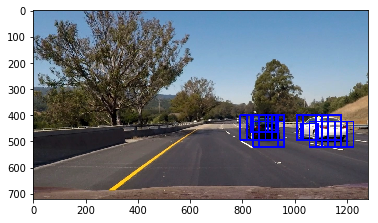

In [27]:
img = mpimg.imread('./test_images/test6.jpg')

scale=1.0
ystart=400
ystop=540
heatmap, bounding_boxes = find_cars(
            img, ystart, ystop, scale, svm_model, orient, pix_per_cell, 
            cells_per_block, cspace, spatial_size, hist_bins)

draw_image = np.copy(img)
draw_bounding_boxes(draw_image,bounding_boxes)

scale=1.5
ystart=400
ystop=656
heatmap2, bounding_boxes2 = find_cars(
            img, ystart, ystop, scale, svm_model, orient, pix_per_cell, 
            cells_per_block, cspace, spatial_size, hist_bins)
draw_bounding_boxes(draw_image,bounding_boxes2)

heatmap = np.add(heatmap, heatmap2)
heatmap = np.clip(heatmap, 0, 255)

plt.imshow(draw_image)

##### False Positives and Duplicates
Add Heatmap to remove false positives

In [28]:
def get_heatmap(img):
    
    ystart = 400
    scales = [1.0, 1.5,2.0]
    ystop = [580,640,720]
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    if len(scales) != len(ystop) :
        raise ValueError("scales and ystop length does not match : %d != %d " % (len(scales), len(ystop)))
    
    for i in range (len(scales)) :
        cur_heatmap, bounding_boxes = find_cars(
            img, ystart, ystop[i], scales[i], svm_model, orient, pix_per_cell, 
            cells_per_block, cspace, spatial_size, hist_bins)
        heatmap = np.add(heatmap, cur_heatmap)
        heatmap = np.clip(heatmap, 0 , 255)
    
    return heatmap

In [29]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

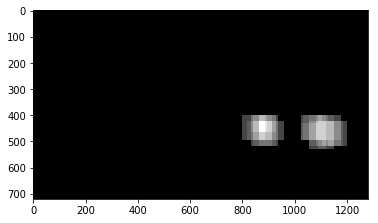

In [30]:

heatmap = get_heatmap(img)
heatmap = apply_threshold(heatmap,2)
plt.imshow(heatmap, cmap='gray')

In [31]:
from scipy.ndimage.measurements import label
labels = label(heatmap)

2 cars found


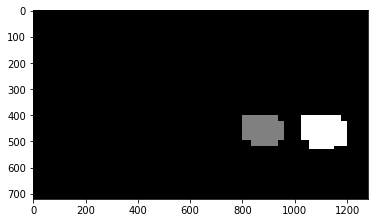

In [32]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [33]:
def draw_labeled_bbox(img, labels):
    draw_image = np.copy(img)

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_image


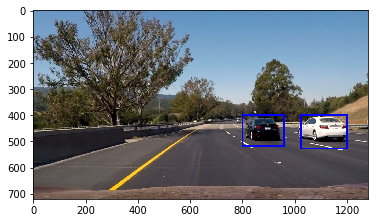

In [34]:
from scipy.ndimage.measurements import label

def get_detected_cars_image(img):
    heatmap = get_heatmap(img)
    heatmap = apply_threshold(heatmap,2)
    labels = label(heatmap)
    return draw_labeled_bbox(img, labels), heatmap

img = mpimg.imread('./test_images/test6.jpg')
detected_img, heatmap = get_detected_cars_image(img)

plt.imshow(detected_img)


Processing image -  ./test_images/test1.jpg
Processing image -  ./test_images/test2.jpg
Processing image -  ./test_images/test3.jpg
Processing image -  ./test_images/test4.jpg
Processing image -  ./test_images/test5.jpg
Processing image -  ./test_images/test6.jpg
Took 8.44 secs


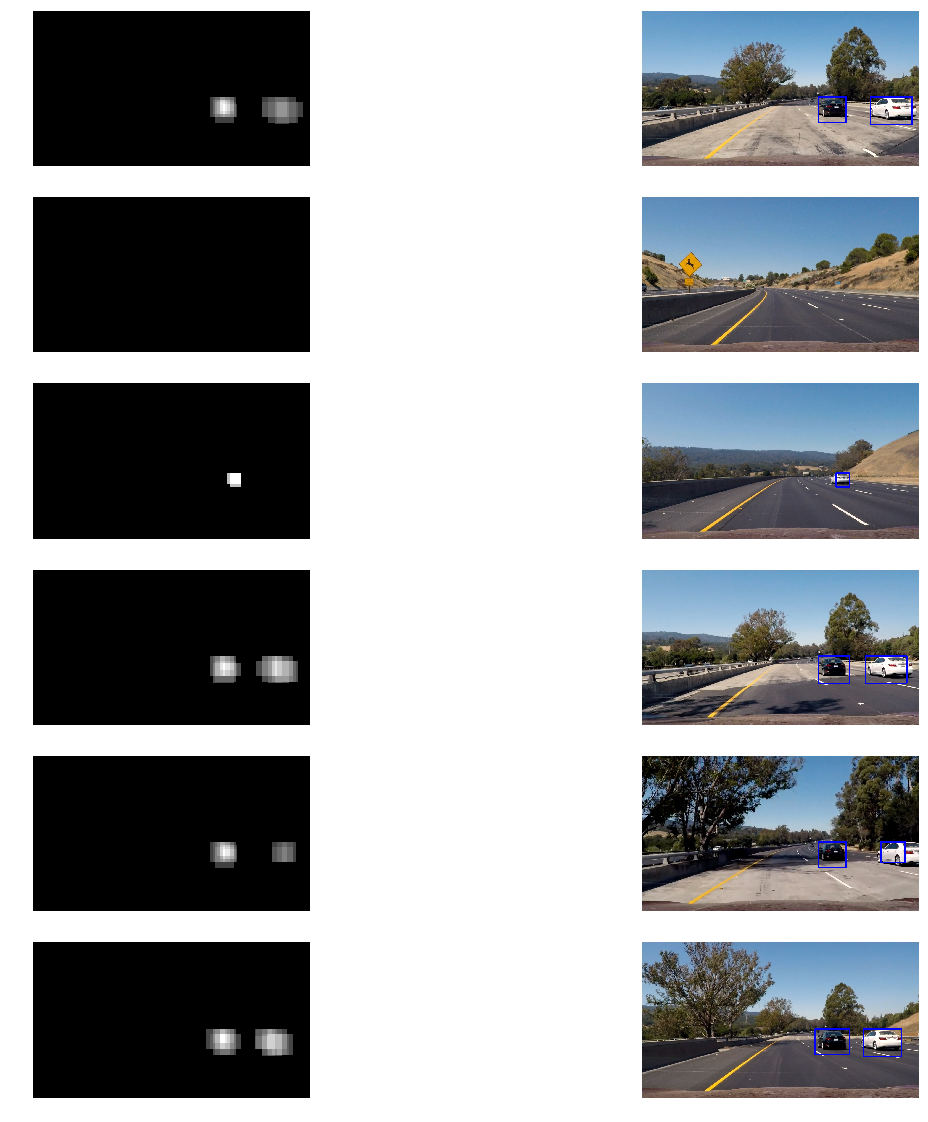

In [35]:
test_images = glob.glob("./test_images/*.jpg")

fig, axes = plt.subplots(len(test_images), 2,figsize=(20,20), squeeze=False)

t1= time.time()
for i, file  in enumerate(test_images) :
    print("Processing image - ",file)
    img = mpimg.imread(file)
    detected_img, heatmap = get_detected_cars_image(img)
    ax1 = axes[i][0]
    ax1.imshow(heatmap, cmap="gray")
    ax1.axis('off')
    ax2 = axes[i][1]
    ax2.imshow(detected_img)
    ax2.axis('off')

t2 = time.time()
print("Took %0.2f secs" % round(t2-t1, 5))

In [36]:
class Tracker() :
    def __init__(self, heat_threshold=3):
        self.frame_nbr = 0
        self.agg_heatmap = None
        self.last_labels = None
        self.heat_threshold = heat_threshold
    
    def find_and_track(self, cur_frame_img) :
        
        #if self.heatmap is None then initialize heatmap
        if self.agg_heatmap is None :
            self.agg_heatmap = np.zeros_like(cur_frame_img[:,:,0]).astype(np.float)
        
        # get heatmap witll scan the image with different scales and returns heatmaps of cars in the image
        cur_frame_heatmap = get_heatmap(cur_frame_img)
        
        # add it to the existing heatmap that we track across frames
        self.agg_heatmap = np.add(self.agg_heatmap, cur_frame_heatmap)
        self.agg_heatmap = np.clip(self.agg_heatmap, 0, 255)
        
        # Smoothing frames: Compute new labels from aggregated heatmap for every 5th frame and 
        # save them to self.last_labels. For all other frames use the labels computed in every 5th frame
        # 
        if self.last_labels is None or self.frame_nbr % 5 == 0 :
            # compute labels after applying threshold and draw the thew new label images
            self.agg_heatmap = apply_threshold(self.agg_heatmap,self.heat_threshold)
            labels = label(self.agg_heatmap)
            draw_image = draw_labeled_bbox(cur_frame_img, labels)
            # store teh labels to be used in the next 3 frames
            self.last_labels = labels
            # reset the agg_heatmap (cooldown)
            self.agg_heatmap = None
        else :
            # draw labeled image from last saved labels
            draw_image = draw_labeled_bbox(cur_frame_img,self.last_labels)
        
        self.frame_nbr += 1
        
        return draw_image
            
            

In [37]:
from scipy.ndimage.measurements import label
def pipeline(img, tracker_obj) :
    return tracker_obj.find_and_track(img)

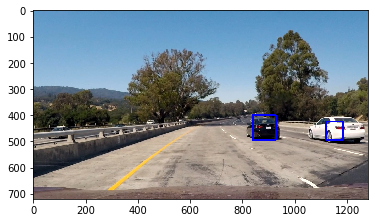

In [38]:
tracker_obj = Tracker(heat_threshold=5)
plt.imshow(pipeline(mpimg.imread("./test_images/test1.jpg"), tracker_obj))

#### Test Video

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [40]:
tracker_obj = Tracker(heat_threshold=4)
def process_image(image):
    result = pipeline(image, tracker_obj)
    return result

In [142]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [23:06<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 22min 51s, sys: 3.38 s, total: 22min 55s
Wall time: 23min 7s


In [143]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))